### Tutorial for CAM visualization 

Completely ripped from [this great blog post](http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html) 

In [1]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt 

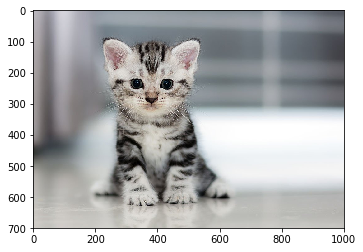

In [2]:
image = Image.open("cat.jpg")
plt.imshow(image)

In [3]:
# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([transforms.Resize((224,224))])

In [4]:
tensor = preprocess(image)
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

In [5]:
resnet = models.resnet18(pretrained=True)
resnet.cuda()
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
# a cleaner mechanism for hooking which takes care of de-registering the hook as well!
class SaveFeatures():
    features=None
    
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
        
    def remove(self): 
        self.hook.remove()

In [7]:
final_layer = resnet._modules.get('layer4')
activated_features = SaveFeatures(final_layer)
prediction = resnet(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
topk(pred_probabilities,1)

/home/nabila/anaconda3/envs/torch1/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


(tensor([0.6498], device='cuda:0'), tensor([285], device='cuda:0'))

#### What do I need for CAM? 
* fully connected weights for the class you care about 
* a convolutional map of features whose channel dim matches the fully connected layer dim 
ie: last conv layer of VGG has 512 channels and the fully connected layer I grab is 512x1000
* implicitely, to get the FC weights for the class I care about, I have to also get the predicted class index so I can index the FC layer to get a matrix of 512x1

In [8]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

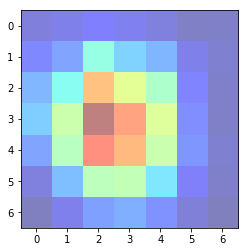

In [9]:
weight_softmax_params = list(resnet._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

weight_softmax.shape
class_idx = topk(pred_probabilities,1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )
imshow(overlay[0], alpha=0.5, cmap='jet')

/home/nabila/anaconda3/envs/torch1/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/nabila/anaconda3/envs/torch1/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


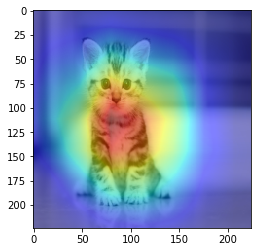

In [10]:
plt.figure()
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')